In [57]:
"""
disclaimer: The following codes were studied and used for this task

Multi-Class Text Classification with Scikit-Learn
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

NLP + feature based points classification
https://www.kaggle.com/mistrzuniu1/nlp-feature-based-points-predictions/

How to use Machine Learning to Predict the Quality of Wines
https://medium.freecodecamp.org/using-machine-learning-to-predict-the-quality-of-wines-9e2e13d7480d

Last updated: 25.08.2018
By: Hye Yeon Kim
"""

'\ndisclaimer: The following codes were studied and used for this task\n\nMulti-Class Text Classification with Scikit-Learn\nhttps://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f\n\nNLP + feature based points classification\nhttps://www.kaggle.com/mistrzuniu1/nlp-feature-based-points-predictions/\n\nHow to use Machine Learning to Predict the Quality of Wines\nhttps://medium.freecodecamp.org/using-machine-learning-to-predict-the-quality-of-wines-9e2e13d7480d\n\nLast updated: 25.08.2018\nBy: Hye Yeon Kim\n'

Part 1: Cleaning and preparing the data

In [58]:
# importing necessary libraries

import pandas as pd
import numpy as np

import string
import nltk 
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split



import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [59]:
# importing data
data = pd.read_csv('wine-reviews\winemag-data-130k-v2.csv')

In [60]:
# checking how data looks like
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [61]:
# dropping unnecessary unnamed columns
data=data.drop('Unnamed: 0', axis=1)
data=data.reset_index(drop=True)

In [62]:
# checking for duplicates
print("Total number of examples: ", data.shape[0])
print("Number of examples with the same title and description: ", data[data.duplicated(['description','title'])].shape[0])

Total number of examples:  129971
Number of examples with the same title and description:  9983


In [63]:
# dropping duplicate wine reviews
data=data.drop_duplicates(['description','title'])
data=data.reset_index(drop=True)

In [64]:
# checking how much of data is missing
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
missing  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing

,Total,Percent
region_2,73219,61.021936
designation,34545,28.790379
taster_twitter_handle,29446,24.540787
taster_name,24917,20.766243
region_1,19560,16.301630
price,8395,6.996533
province,59,0.049172
country,59,0.049172
variety,1,0.000833
winery,0,0.000000


In [65]:
# dropping NA values in our target, taster_name
data=data.dropna(subset=['taster_name'])
data=data.reset_index(drop=True)

Part 2: (a quick) Exploratory Data Analysis

In [66]:
# adding description length in the data
data['length'] = data['description'].apply(len)

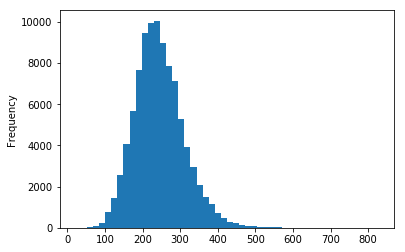

In [67]:
# checking the distrbution of description length
data['length'].plot(bins=50, kind='hist')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028AD3D5C4E0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000028A802D8BE0>]], dtype=object)

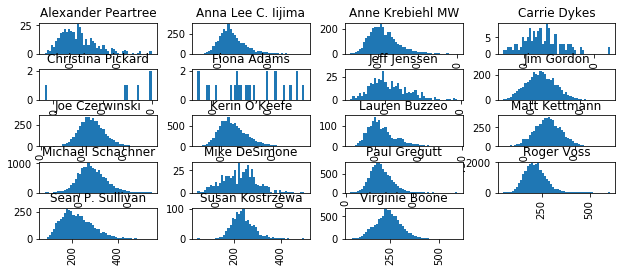

In [68]:
# checking if there is visible difference of description length with each taster
data.hist(column='length', by='taster_name', bins=50, figsize=(10,4))

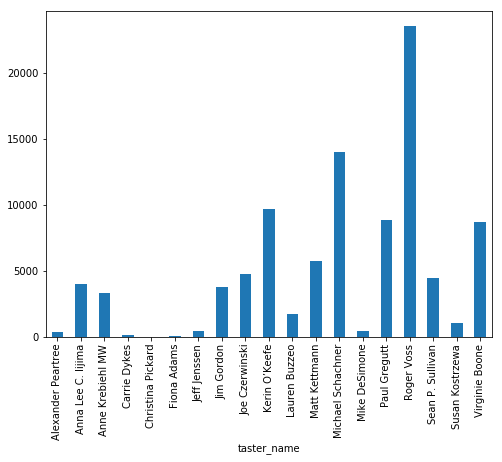

In [69]:
# checking how many descriptions are there per each taster
fig = plt.figure(figsize=(8,6))
data.groupby('taster_name').description.count().plot.bar(ylim=0)

Part 3: Natural Language Processing

In [70]:
# preparing data for training by creating a smaller dataframe and by giving id to each taster

from io import StringIO

# creating a new data frame of taster_name and description
col = ['taster_name', 'description']
df = data[col]
df = df[pd.notnull(df['description'])]
df = df[pd.notnull(df['taster_name'])]
df.columns = ['taster_name', 'description']

# giving id to each taster
data['taster_id'] = data['taster_name'].factorize()[0]
taster_id_df = data[['taster_name', 'taster_id']].drop_duplicates().sort_values('taster_id')
taster_to_id = dict(taster_id_df.values)
id_to_taster = dict(taster_id_df[['taster_id', 'taster_name']].values)

# checking how it looks
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,length,taster_id
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,172,0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,227,1
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,186,2
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,199,3
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,249,2


In [71]:
# importing more libraries for language processing

from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.tokenize import RegexpTokenizer

In [72]:
# for text preprocessing

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)  
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [73]:
# checking if text_process works
data.description.head(5).apply(text_process)

0    [Aromas, include, tropical, fruit, broom, brim...
1    [ripe, fruity, wine, smooth, still, structured...
2    [Tart, snappy, flavors, lime, flesh, rind, dom...
3    [Pineapple, rind, lemon, pith, orange, blossom...
4    [Much, like, regular, bottling, 2012, comes, a...
Name: description, dtype: object

Part 4: Training and Testing the data

In [74]:
# creating a pipeline to fit data
pipeline = Pipeline([('bow', CountVectorizer(analyzer=text_process)),
                    ('tfidf', TfidfTransformer()),
                     ('classifier', MultinomialNB())                 
                    ])

In [75]:
# splitting the data for training set and test set
dat_train, dat_test, name_train, name_test = train_test_split(data['description'], data['taster_name'], test_size =0.2)

In [76]:
# training the model
pipeline.fit(dat_train, name_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x0000028A809FB730>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [77]:
# predicting with the model
predictions = pipeline.predict(dat_test)

In [78]:
# prediction results
print(classification_report(predictions, name_test))

                    precision    recall  f1-score   support

Alexander Peartree       0.00      0.00      0.00         0
Anna Lee C. Iijima       0.80      0.98      0.88       665
  Anne Krebiehl MW       0.64      1.00      0.78       433
      Carrie Dykes       0.00      0.00      0.00         0
       Fiona Adams       0.00      0.00      0.00         0
      Jeff Jenssen       0.00      0.00      0.00         0
        Jim Gordon       0.34      1.00      0.51       261
    Joe Czerwinski       0.46      1.00      0.63       436
     Kerin O’Keefe       1.00      0.89      0.94      2132
     Lauren Buzzeo       0.03      1.00      0.05         8
     Matt Kettmann       0.94      0.97      0.95      1110
 Michael Schachner       0.99      0.73      0.84      3884
     Mike DeSimone       0.00      0.00      0.00         0
      Paul Gregutt       0.88      0.85      0.86      1871
        Roger Voss       1.00      0.83      0.91      5705
  Sean P. Sullivan       0.74      1.00

C:\Users\heyon\Anaconda2\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Part 5: Different approaches of training and testing the data

In [79]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor, cv

In [80]:
# feature extraction for further usage of different models
vect = TfidfVectorizer(analyzer='word', stop_words ='english', ngram_range=(1, 2), token_pattern=r'\w+',max_features=500)
features = vect.fit_transform(data['description']).toarray()
labels = data.taster_id
features.shape

(95071, 500)

In [81]:
# checking related features for each taster
from sklearn.feature_selection import chi2

N = 2
for taster_name, taster_id in sorted(taster_to_id.items()):
  features_chi2 = chi2(features, labels == taster_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(vect.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(taster_name))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Alexander Peartree':
  . Most correlated unigrams:
. nose
. tones
  . Most correlated bigrams:
. medium bodied
. nose palate
# 'Anna Lee C. Iijima':
  . Most correlated unigrams:
. brisk
. riesling
  . Most correlated bigrams:
. apple pear
. lemon lime
# 'Anne Krebiehl MW':
  . Most correlated unigrams:
. lovely
. freshness
  . Most correlated bigrams:
. white pepper
. nose palate
# 'Carrie Dykes':
  . Most correlated unigrams:
. carry
. long
  . Most correlated bigrams:
. red currant
. red plum
# 'Christina Pickard':
  . Most correlated unigrams:
. silky
. valley
  . Most correlated bigrams:
. fruit aromas
. white pepper
# 'Fiona Adams':
  . Most correlated unigrams:
. currant
. cedar
  . Most correlated bigrams:
. white pepper
. black currant
# 'Jeff Jenssen':
  . Most correlated unigrams:
. juice
. mouth
  . Most correlated bigrams:
. green apple
. black plum
# 'Jim Gordon':
  . Most correlated unigrams:
. bodied
. aroma
  . Most correlated bigrams:
. medium bodied
. bodied wine


In [82]:
# preparing to compare different models

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

In [83]:
# implementing different models and appending the accuracy results
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

In [84]:
# creating a dataframe of accuracy of different models used
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.head()

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.429375
1,RandomForestClassifier,1,0.430480
2,RandomForestClassifier,2,0.426633
3,RandomForestClassifier,3,0.427459
4,RandomForestClassifier,4,0.431450


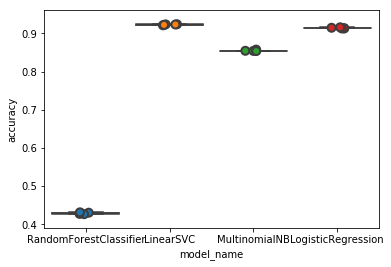

In [85]:
# visualizing the accuracy of different models
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [86]:
# comparing accuracy of prediction results of different models
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.922732
LogisticRegression        0.913907
MultinomialNB             0.854824
RandomForestClassifier    0.429079
Name: accuracy, dtype: float64

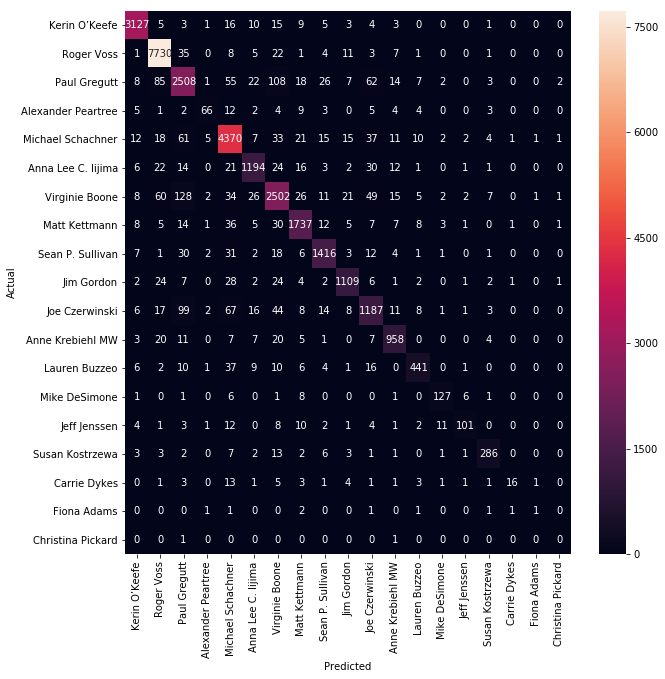

In [87]:
# visualizing confusion matrix to check the prediction results
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=taster_id_df.taster_name.values, yticklabels=taster_id_df.taster_name.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Comments:

1. I did try using other features in the reviews table, but decided to use only description as a feature, to focus on natural language processing.
2. In part 5, trying with other models for training and testing the data, I only used Tfidf feature extraction to make the process simpler, instead of using a bit more extensive pipeline.
3. I know it takes too long to run the code, but since I am a novice in pyspark, tensorflow, and keras (all of which I would have liked to use), I could not make it work, so I just chose what worked in the end.

Next Steps (personal agenda):

1. Hyperparameter fine-tuning with GridSearchCV
2. Changing the code to apply it to pyspark
3. Using Tensorflow, Keras for faster process 